In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
library(parallel)
library(ggplot2)
library("ggtern")
library(viridis)
library(scales)
library(RColorBrewer)

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplotGrob, ggplot_build, ggplot_gtable,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




In [2]:
meta_data=read.csv("/home/workspace/IHA_Figure_Revision//Dataset/SF4_meta_data-2024-05-05.csv")
meta_data$ageAtEnrollment[meta_data$ageAtEnrollment == '89+'] <- '90'
meta_data$ageAtEnrollment<-as.numeric(meta_data$ageAtEnrollment)
meta_data<-meta_data[!is.na(meta_data$ageAtEnrollment),]
meta_data$Ages<-meta_data$ageAtEnrollment

# Read NMF score for Year 1 Day 0 Samples

In [3]:
df<-read.csv("01_NMF_CD4_T_cell_Projection/NMF_Scores_SF4.csv")

In [4]:
df<-df %>% filter(NMF_Scores %in% c('NMF0_Cytotoxic', 'NMF2_Th17',  
                                                    'NMF5_Th2', 'NMF6_Tfh',  
                                                    'NMF8_Cent_Mem', 'NMF11_Th1'))%>% 
                           filter(AIFI_L3 %in% c('CM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'GZMB- CD27- EM CD4 T cell'))

In [5]:
df_median<-df %>%
  group_by(AIFI_L3, pbmc_sample_id,NMF_Scores) %>%
  summarise(AverageScore_median = median(AverageScore, na.rm = TRUE)) %>%
  spread(NMF_Scores, AverageScore_median) 

`summarise()` has grouped output by 'AIFI_L3', 'pbmc_sample_id'. You can
override using the `.groups` argument.


In [6]:
df_median<-left_join(df_median,meta_data,by=c('pbmc_sample_id'))

In [7]:
df_median$NMF11_Th1<-scale(df_median$NMF11_Th1,center = FALSE)
df_median$NMF5_Th2<-scale(df_median$NMF5_Th2,center = FALSE)
df_median$NMF2_Th17<-scale(df_median$NMF2_Th17,center = FALSE)

In [9]:
write.csv(df_median %>%
    ungroup()%>%
    filter(AIFI_L3 == "CM CD4 T cell")%>% select(pbmc_sample_id,AIFI_L3,NMF5_Th2,NMF11_Th1,NMF2_Th17, Ages) ,
          "/home/workspace/Source_Data/Fig5c.csv", row.names=FALSE)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


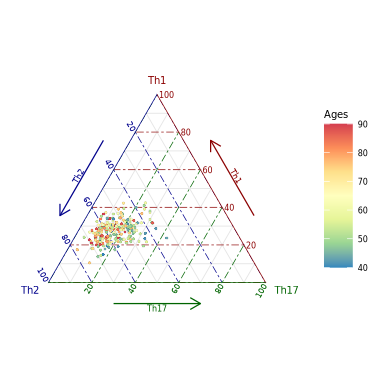

In [10]:
options(repr.plot.width = 80/25.4, repr.plot.height = 80/25.4)
#USE THIS ONE!

p <- ggtern(data = df_median %>%
              ungroup() %>%
              filter(AIFI_L3 == 'CM CD4 T cell') %>% arrange(Ages),
            aes(NMF5_Th2, NMF11_Th1, NMF2_Th17,
                color = Ages,
                fill = Ages)) +
  geom_point(size = 0.8, shape = 21,stroke = 0.03, color = 'black') +  # Use shape=21 with stroke for black border
  theme_rgbw(base_size = 6) +
  labs(x = "Th2", y = "Th1", z = "Th17") +
  scale_T_continuous(limits = c(0, 1)) +
  scale_L_continuous(limits = c(0, 1)) +
  scale_R_continuous(limits = c(0, 1)) +
  scale_color_distiller(palette = "Spectral", direction = -1) +  # Use RdYlBu for color
  scale_fill_distiller(palette = "Spectral", direction = -1) +   # Use RdYlBu for fill
  theme(
    tern.panel.grid.major = element_line(linewidth = 0.2),
    tern.axis.line = element_line(linewidth = 0.2),,
     tern.axis.arrow = element_line(size = 1)
  )

p
ggsave("FigureK.pdf",p, width=80/25.4,height = 80/25.4)